In [1]:
import csv
import numpy as np
import matplotlib.pyplot as plt
import juliet
import sys
import time

#get times, normalised fluxes and fluxes error from specific quarter and section

#specify quarter and section from command line
quarter = input('Insert quarter number')
section = input('Insert section number')

#add 0 in front of numbers less than 10 (e.g 8 becomes 08)
if int(quarter) < 10:
    quarter = '0'+ quarter

#create variable qs as specified quarter and section
qs = '_q' + quarter + '_' + section

with open('Mstar/KIC4150611'+qs+'.csv', 'r') as qs_csv:
    #turn csv file into an object
    qs_object = csv.reader(qs_csv)

    #create empty arrays for t,f,ferr to fill in
    t = np.array([])
    f = np.array([])
    ferr = np.array([])

    #skip headings before looping
    next(qs_object)

    #loop through each line, fill t,f,ferr array with data
    for line in qs_object:
        t = np.append(t,float(line[0]))
        f = np.append(f,float(line[1]))
        ferr = np.append(ferr,float(line[2]))

ValueError: invalid literal for int() with base 10: ''

Text(0, 0.5, 'Relative flux')

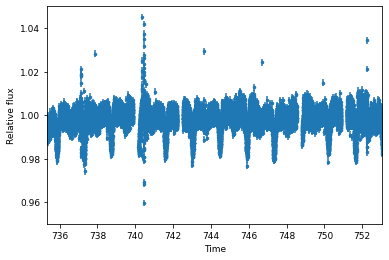

In [19]:
#Lightcurve (not-fitted):
plt.errorbar(t, f, yerr=ferr, fmt='.')
plt.xlim([np.min(t),np.max(t)])
plt.ylim([0.95,1.05])

plt.xlabel('Time')
plt.ylabel('Relative flux')

In [20]:
#create dictionaries for times, normalised fluxes and fluxes error and fill with data into key 'TESS'
times, fluxes, fluxes_error = {},{},{}
times['TESS'], fluxes['TESS'], fluxes_error['TESS'] = t,f,ferr

# Define parameters and their distributions and hyperparameters for priors dictionary
# Note: not including period P_p1 and time of starting transit t0_p1, will find this via least regression
params = ['r1_p1','r2_p1','q1_TESS','q2_TESS','ecc_p1','omega_p1',
          'rho', 'mdilution_TESS', 'mflux_TESS', 'sigma_w_TESS']

dists = ['uniform','uniform','uniform','uniform','fixed','fixed',
         'loguniform', 'fixed', 'normal', 'loguniform']

hyperps = [[0.,1], [0.,1.], [0., 1.], [0., 1.], 0.0, 90.,
           [100., 10000.], 1.0, [0.,0.1], [0.1, 1000.]]

In [32]:
#starting time T0 and period results from manual fit => use to estimate transit times
T0 = 735.8617593679
P = 1.4342657442

#create an array of estimated transit times
transit_times = []
transit_numbers = []
#case 1: T0 < t[0]
if T0 < t[0]:
    while T0 < t[0]:
        T0 = T0 + P

    transit_times.append(T0)

    while T0 < t[len(t)-1]:
        T0 = T0 + P
        transit_times.append(T0)

    transit_times.pop()

elif T0 > t[len(t)-1]:
    while T0 > t[len(t)-1]:
        T0 = T0 - P

    transit_times.append(T0)

    while T0 > t[0]:
        T0 = T0 - P
        transit_times.append(T0)

    transit_times.pop()

    transit_times.reverse()

else:
    while T0 > t[0]:
        T0 = T0 - P

    while T0 < t[len(t)-1]:
        T0 = T0 + P
        transit_times.append(T0)

    transit_times.pop()

print(transit_times)

[735.8617593679, 737.2960251121001, 738.7302908563001, 740.1645566005002, 741.5988223447002, 743.0330880889003, 744.4673538331003, 745.9016195773004, 747.3358853215004, 748.7701510657005, 750.2044168099005, 751.6386825541006]


In [30]:
T0

753.0729482983006

In [84]:
# Add transit times to parameters, and corresponding distributions and hyperparameters :
i = 0
j = 0
while i < len(transit_times):

#checks if there is data at estimated transit time
    while t[j] < transit_times[i]:
        j = j + 1

#if there is no data within approx 30 mins  (0.021 days)
    if abs(t[j]-transit_times[i]) > 0.021 or abs(t[j-1]-transit_times[i]) > 0.021:
        i = i + 1
        continue

    params.append('T_p1_TESS_' + str(i))
    dists.append('normal')
    hyperps.append([transit_times[i], 0.1])
    transit_numbers.append(i)
    i = i + 1

print(params, dists, hyperps, transit_numbers)

['r1_p1', 'r2_p1', 'q1_TESS', 'q2_TESS', 'ecc_p1', 'omega_p1', 'rho', 'mdilution_TESS', 'mflux_TESS', 'sigma_w_TESS', 'T_p1_TESS_0', 'T_p1_TESS_1', 'T_p1_TESS_3', 'T_p1_TESS_4', 'T_p1_TESS_7', 'T_p1_TESS_9', 'T_p1_TESS_10', 'T_p1_TESS_11', 'T_p1_TESS_12', 'T_p1_TESS_13', 'T_p1_TESS_15', 'T_p1_TESS_16', 'T_p1_TESS_17', 'T_p1_TESS_18', 'T_p1_TESS_19'] ['uniform', 'uniform', 'uniform', 'uniform', 'fixed', 'fixed', 'loguniform', 'fixed', 'normal', 'loguniform', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal'] [[0.0, 1], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], 0.0, 90.0, [100.0, 10000.0], 1.0, [0.0, 0.1], [0.1, 1000.0], [754.5072140425007, 0.1], [755.9414797867007, 0.1], [758.8100112751008, 0.1], [760.2442770193009, 0.1], [764.547074251901, 0.1], [767.4156057403011, 0.1], [768.8498714845011, 0.1], [770.2841372287012, 0.1], [771.7184029729012, 0.1], [773.1526687171013, 0.1], [776.0212002055014, 0

In [74]:
# Build the prior dictionary with the above information:
priors = juliet.utils.generate_priors(params,dists,hyperps)

#check
print

{'r1_p1': {'distribution': 'uniform', 'hyperparameters': [0.0, 1]}, 'r2_p1': {'distribution': 'uniform', 'hyperparameters': [0.0, 1.0]}, 'q1_TESS': {'distribution': 'uniform', 'hyperparameters': [0.0, 1.0]}, 'q2_TESS': {'distribution': 'uniform', 'hyperparameters': [0.0, 1.0]}, 'ecc_p1': {'distribution': 'fixed', 'hyperparameters': 0.0}, 'omega_p1': {'distribution': 'fixed', 'hyperparameters': 90.0}, 'rho': {'distribution': 'loguniform', 'hyperparameters': [100.0, 10000.0]}, 'mdilution_TESS': {'distribution': 'fixed', 'hyperparameters': 1.0}, 'mflux_TESS': {'distribution': 'normal', 'hyperparameters': [0.0, 0.1]}, 'sigma_w_TESS': {'distribution': 'loguniform', 'hyperparameters': [0.1, 1000.0]}, 'T_p1_TESS_0': {'distribution': 'normal', 'hyperparameters': [691.3995212976986, 0.1]}, 'T_p1_TESS_1': {'distribution': 'normal', 'hyperparameters': [692.8337870418986, 0.1]}, 'T_p1_TESS_2': {'distribution': 'normal', 'hyperparameters': [694.2680527860987, 0.1]}, 'T_p1_TESS_3': {'distribution': 

In [75]:
# Load and fit dataset with juliet:
dataset = juliet.load(priors=priors, t_lc = times, y_lc = fluxes, yerr_lc = fluxes_error, out_folder = 'KIC4150611_TTV'+qs)

In [57]:
t1 = time.time()
results = dataset.fit(use_dynesty=True)
t2 = time.time()
print(t2-t1)

Detected dynesty sampler output files --- extracting from KIC4150611_TTV_q08_2/_dynesty_NS_posteriors.pkl
0.1760241985321045


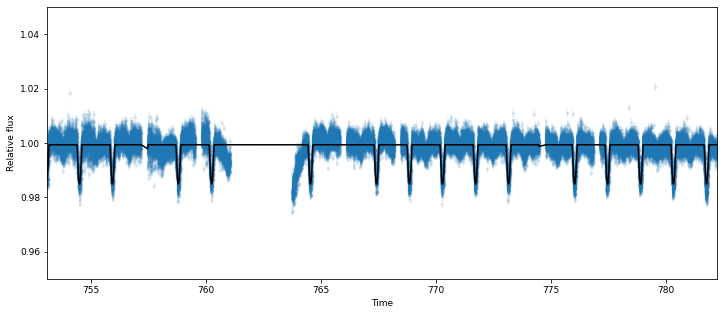

In [58]:
# Extract median model and the ones that cover the 68% credibility band around it:
transit_model = results.lc.evaluate('TESS')

# Plot data and best-fit model:
fig = plt.figure(figsize=(12,5))
plt.errorbar(dataset.times_lc['TESS'], dataset.data_lc['TESS'], \
          yerr = dataset.errors_lc['TESS'], fmt = '.' , alpha = 0.1)
plt.plot(dataset.times_lc['TESS'], transit_model, color='black',zorder=10)

# Define labels, limits, etc. of the plot:
plt.xlim([np.min(dataset.times_lc['TESS']),np.max(dataset.times_lc['TESS'])])
plt.ylim([0.95,1.05])
plt.xlabel('Time')
plt.ylabel('Relative flux')
#plt.savefig('Lightcurve' + qs + '.png')
plt.show()

Text(0, 0.5, 'O-C (minutes)')

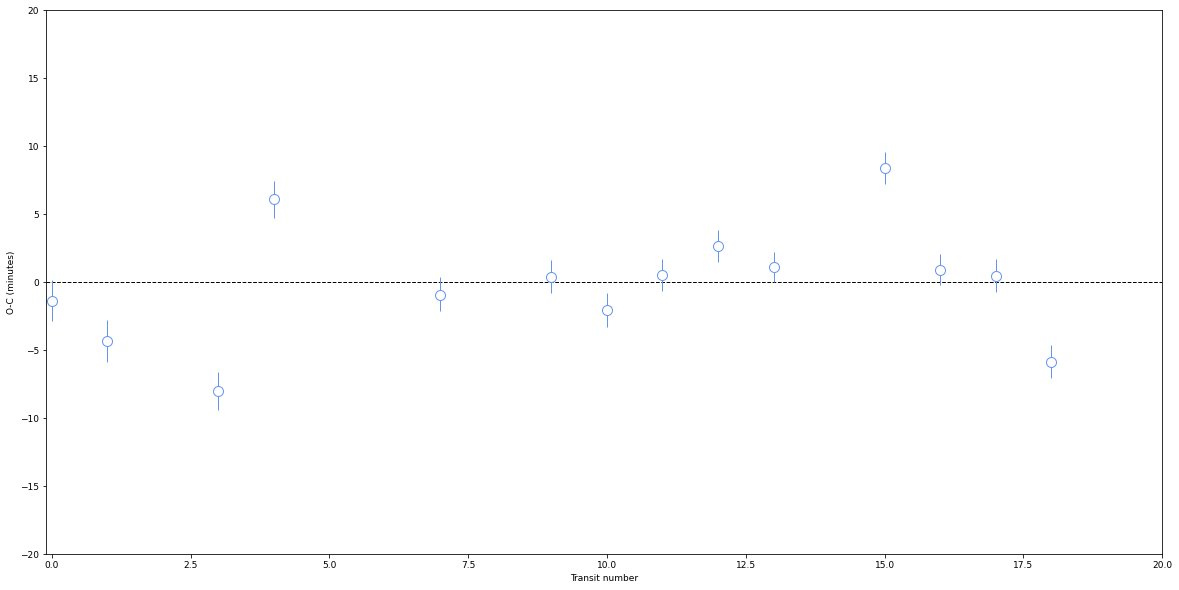

In [59]:
# To extract O-C data from the posterior distributions, first define some variables:
OC = np.zeros(len(transit_numbers))
OC_up_err = np.zeros(len(transit_numbers))
OC_down_err = np.zeros(len(transit_numbers))
instrument = 'TESS'

#perhaps troubleshoot cases where there are no transits -> error bars become very big


# Now go through known transit-numberings, and generate the O-C distributions. From there,
# compute the medians and 68% credibility bands:
for k in range(len(transit_numbers)):
    transit_number = transit_numbers[k]
    # Compute distribution of predicted times:
    computed_time = results.posteriors['posterior_samples']['t0_p1'] + transit_number*results.posteriors['posterior_samples']['P_p1']
    # Extract observed times:
    observed_time = results.posteriors['posterior_samples']['T_p1_'+instrument+'_'+str(transit_number)]
    # Generate O-C (multiply by 24*60 to get it in minutes) posterior distribution,
    # and get quantiles from it:
    val,vup,vdown = juliet.utils.get_quantiles((observed_time - computed_time)*24*60.)
    # Save value and "1-sigma" errors:
    OC[k], OC_up_err[k], OC_down_err[k] = val, vup-val,val-vdown

# Finally, generate plot with the O-C:
fig = plt.figure(figsize=(20,10))
plt.errorbar(transit_numbers,OC,yerr=[OC_down_err,OC_up_err],fmt='o',mfc='white',mec='cornflowerblue',ecolor='cornflowerblue',ms=10,elinewidth=1,zorder=3)
plt.plot([-0.1,len(transit_times)],[0.,0],'--',linewidth=1,color='black',zorder=2)
plt.xlim([-0.1,len(transit_times)])
plt.ylim([-20,20])
plt.xlabel('Transit number')
plt.ylabel('O-C (minutes)')
#plt.savefig('oc' + qs +'.png',transparent=True)

In [24]:
transit_numbers

[0, 1, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 15, 16, 17, 18]

In [61]:
transit_numbers

[0, 1, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 15, 16, 17, 18]

In [32]:
len(transit_times)

20

In [33]:
qs

'_q08_1'

In [67]:
abs(-2)

2

In [5]:
t[0]

735.3530459893445